# Import and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import functions_simulation as sim
snscolors=sns.color_palette() 
import scipy.optimize

# Parameters and settings

In [2]:
savedir='simresults/'

tau_patch_values=[1.5,5]
Ttravelvalues=[1,5,10]
Evalues=[0.5,2,5]
s=sim.s
betavalues = [0,0.1,0.3]

# Plot each marginal utility function  (Fig 5A-B)

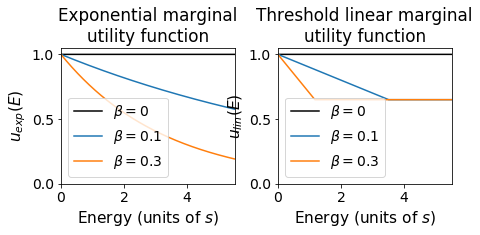

In [4]:
lsize=14

f,ax=plt.subplots(1,2)
f.set_size_inches((7,2.5))
etp=np.arange(0,5.5001,.001)
for unum in [0,1]:
    a=ax[unum]
    if unum==0:  # exponential
        def ufn(E,beta,A=0):
            return (1-A)*np.exp(-beta*E) + A        
    elif unum==1:  #linear, with threshold of 0.65
        def ufn(E,beta,A=0.65):
            return (1-beta*E) * np.heaviside(1-beta*E-A,0) + A*np.heaviside(A-1+beta*E,1)    
    for bnum in range(len(betavalues)):
        b=betavalues[bnum]
        if bnum==0:
            clr='k'
        else:
            clr=snscolors[bnum-1]        
        a.plot(etp,ufn(etp,b),label='$\\beta=$'+str(b),c=clr)
    
[a.legend(fontsize=lsize) for a in ax]
[a.set_ylim([0,1.05]) for a in ax]
[a.set_xlim([0,5.5]) for a in ax]
[a.tick_params(labelsize=lsize) for a in ax]
[a.set_xlabel('Energy (units of $s$)',fontsize=lsize*1.1) for a in ax]

ax[0].set_ylabel('$u_{exp}(E)$',fontsize=lsize*1.1)
ax[1].set_ylabel('$u_{lin}(E)$',fontsize=lsize*1.1)

ax[0].set_title('Exponential marginal\nutility function',fontsize=lsize*1.2)
ax[1].set_title('Threshold linear marginal\nutility function',fontsize=lsize*1.2)

plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.show()

# Read in results and plot

## Read in results

In [6]:
[grid_Eresults,grid_Tresults,grid_prts,grid_traveltimes,grid_rho0,grid_taupatch,grid_numfood] = pickle.load(open(savedir+'fig5-utilitysims.pkl' , "rb" ))
  
grid_Eresults = np.array(grid_Eresults)
grid_Tresults = np.array(grid_Tresults)        

# Changes in optimal energy, when have sigmarho0
def Eopt_with_sigmarho0(E):
    # I solved this numerically in mathematica, and then fit a linear function to the results.  Its only a small correction
    return 0.0256307 + 1.02563*np.array(E)

## Get approximate numerical solution to compare with simulation results

In [7]:
#%%  Numerical solution, when have values of beta - 
tpnum=1
Ttrnum=1
tau_patch=tau_patch_values[tpnum]
Ttravel=Ttravelvalues[Ttrnum]

alphachoice=1

evalues = np.arange(0,5.51,0.01)

linelabels=betavalues
xlabel = '$E_{opt}$'

Tsols = np.zeros((2,2,len(betavalues),len(evalues)))
Esols = np.zeros((2,2,len(betavalues),len(evalues)))

for unum in [0,1]:
    if unum==0:  # exponential
        def ufn(E,beta,A=0):
            return (1-A)*np.exp(-beta*E) + A        
    elif unum==1:  #linear, with threshold of 0.5
        def ufn(E,beta,A=0.65):
            return (1-beta*E) * np.heaviside(1-beta*E-A,0) + A*np.heaviside(A-1+beta*E,1)    
        
    for anum in range(2):
        alphachoice=[1,-0.2][anum]
        signeta = np.sign(alphachoice)
          
        for bnum in range(len(betavalues)):    
            beta = betavalues[bnum]
            
            for Enum in range(len(evalues)):
                Evalue=evalues[Enum]
                rho0=sim.getrho0_Eopt(Evalue,tau_patch,Ttravel)
                alpha=alphachoice*rho0
                Topt=tau_patch*np.log(rho0/(Evalue+s))    
                
                if Enum==0:
                    prevsol=Topt
                else:
                    prevsol=Tsols[unum,anum,bnum,Enum-1]
        
                energyfn = lambda T: (rho0*tau_patch*(1-np.exp(-T/tau_patch)) - s*(T+Ttravel))/(T+Ttravel)            
                tosolve = lambda T: sim.eta_opt(energyfn(T),rho0,tau_patch,alpha) - (  alpha*T*ufn(energyfn(T),beta)-rho0*tau_patch*(1-np.exp(-T/tau_patch))*ufn(energyfn(T),beta)**(-signeta))
                Tsol = scipy.optimize.newton(tosolve,prevsol)
                Tsols[unum,anum,bnum,Enum]=Tsol
                Esols[unum,anum,bnum,Enum]=energyfn(Tsol)        
    

## Figure 3 and S4:  grid plots of results

Note that Figure 3 shows the "upper left" plots from each one of these, i.e. For the density adaptive strategy (left columns) in the environment with uncertain patch food density.

See Figure S4 for labels

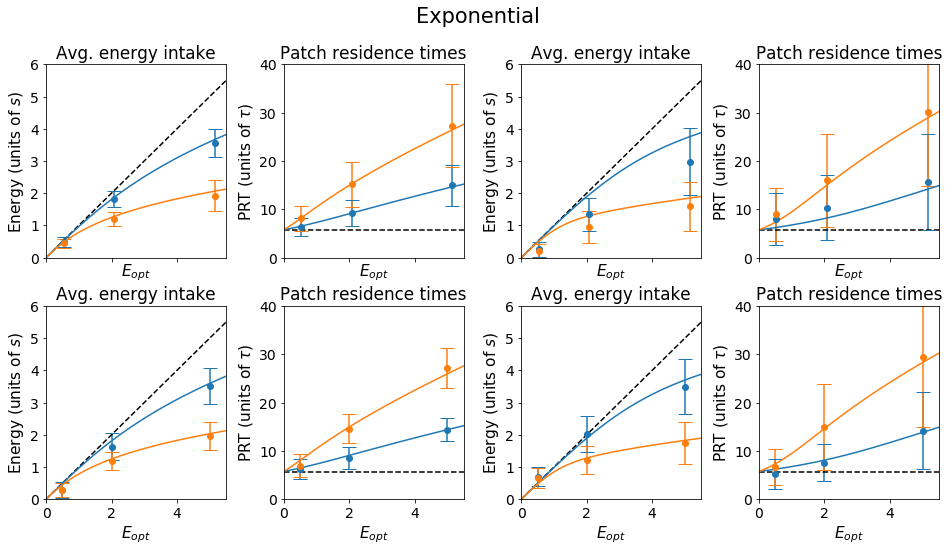

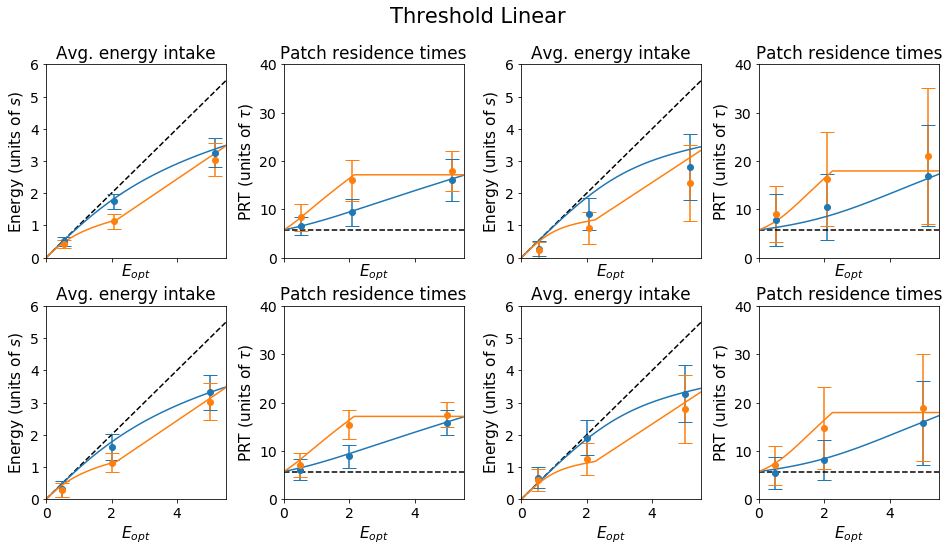

In [8]:
#%%  PLOTS for a grid ranges of cases
 

ulabels=['Exponential','Threshold Linear']
for unum in [0,1]:  # for the different utility functions
    
    f, ax= plt.subplots(2,4,sharex=True)
    f.set_size_inches(16,8)
    plt.suptitle(ulabels[unum],size=1.5*lsize)
    axE = [ax[0,0],ax[0,2],ax[1,0],ax[1,2]]
    axT = [ax[0,1],ax[0,3],ax[1,1],ax[1,3]]
    
    # first, plot optimal values
    tpe = np.arange(0,5.51,0.1)
    [ax0.plot(tpe,tpe,'k--') for ax0 in axE]
    Topt=tau_patch*np.log(rho0/(Evalue+s))  # this doesn't change, so just calculate it once
    [ax1.plot(tpe,Topt*np.ones(len(tpe)),'k--') for ax1 in axT]
    
    for env in range(2):
        for anum in range(2):  # strategies
            ax0=ax[env,0+2*anum]
            ax1=ax[env,1+2*anum]    
            for bnum in range(1,3):
                if bnum==0:
                    clr='k'
                else:
                    clr=snscolors[bnum-1]
                if env==0:
                    tpEopt = Eopt_with_sigmarho0(Evalues)
                else:
                    tpEopt = grid_Eresults[env,anum,:,unum,bnum,0]
                ax0.errorbar(tpEopt, grid_Eresults[env,anum,:,unum,bnum,1], yerr=grid_Eresults[env,anum,:,unum,bnum,2], fmt='o', capsize=7,c=clr,label='Strategy '+str(anum+1))
                ax1.errorbar(tpEopt, grid_Tresults[env,anum,:,unum,bnum,1], yerr=grid_Tresults[env,anum,:,unum,bnum,2], fmt='o', capsize=7,c=clr,label='Strategy '+str(anum+1))
                
            for bnum in range(1,len(betavalues)):
                ax0.plot(evalues,Esols[unum,anum,bnum],c=snscolors[bnum-1],label=linelabels[bnum])
                ax1.plot(evalues,Tsols[unum,anum,bnum],c=snscolors[bnum-1],label=linelabels[bnum])        
    
    
    [ax0.set_ylim([0,6]) for ax0 in axE]
    [ax1.set_ylim([0,40]) for ax1 in axT]
    [ax0.set_ylabel('Energy (units of $s$)',fontsize=lsize*1.1) for ax0 in axE]
    [ax0.set_title('Avg. energy intake',fontsize=lsize*1.2) for ax0 in axE]
    [ax1.set_ylabel('PRT (units of $\\tau$)',fontsize=lsize*1.1) for ax1 in axT]
    [ax1.set_title('Patch residence times',fontsize=lsize*1.2) for ax1 in axT]
    ax[0,0].set_xlim([0,np.max(tpe)])
    [[a.set_xlabel(xlabel,fontsize=lsize*1.1) for a in a2] for a2 in ax]
    [[a.tick_params(labelsize=lsize) for a in a2]     for a2 in ax]
    plt.subplots_adjust(wspace=0.32,hspace=0.25)    
    plt.show()

# Do the distributions of patch residence times for the different strategies look different?

This is not included in the paper, but was just done to examine the distributions, to ask if in cases where the mean patch residence was the same, the strategy could be distinguished by the distribution of patch residence times.  

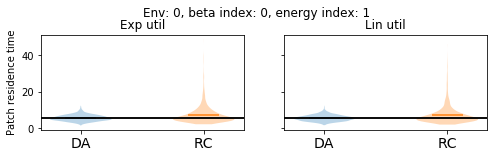

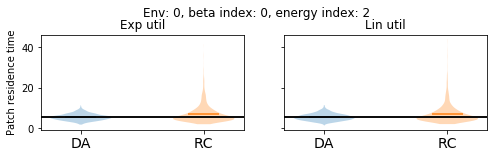

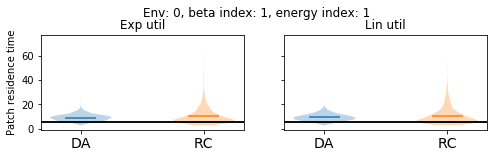

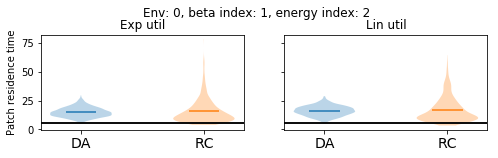

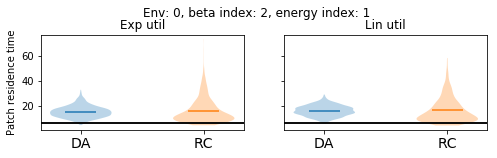

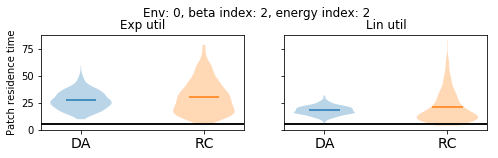

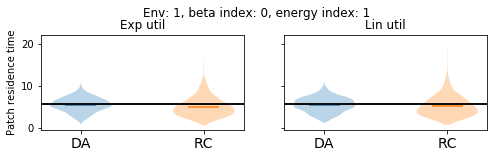

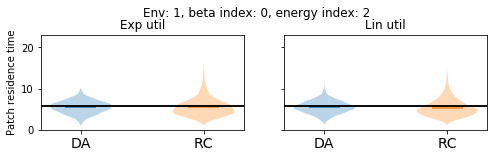

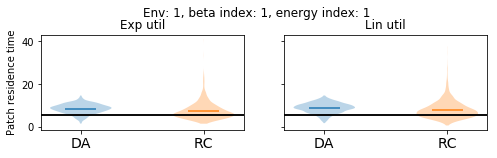

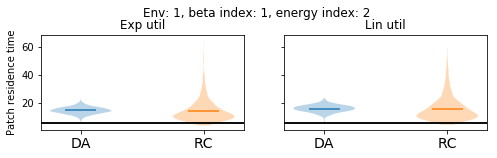

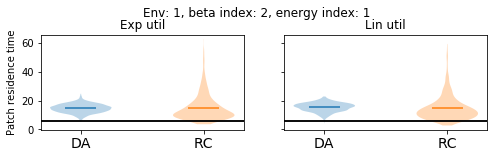

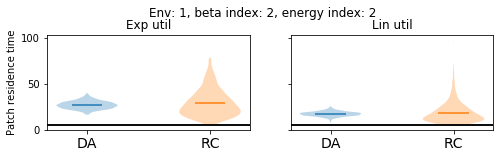

In [11]:
# loop through and show a bunch of plots, to explore this
#%%  See if the distributions of patch residence times look difference
for env in range(2):
    for bnum in range(3):
        for Enum in range(1,3):            
            f,ax = plt.subplots(1,2,sharex=True,sharey=True)
            f.set_size_inches(8,1.75)
            for anum in range(2):  # which strategy
                for unum in range(2):  # which util
                    a = ax[unum]
                    a.set_title(['Exp util','Lin util'][unum])
                    a.violinplot(grid_prts[env][anum][Enum][unum][bnum],positions=[anum],showextrema=False,showmeans=True)
                    a.axhline(grid_Tresults[env,anum,Enum,unum,bnum,0],c='k')
                    a.set_xticks([0,1])
                    a.set_xticklabels(['DA','RC'],fontsize=14)
            ax[0].set_ylabel('Patch residence time')
            plt.suptitle('Env: '+str(env)+', beta index: '+str(bnum)+', energy index: '+str(Enum),y=1.1)
            plt.show()

# Run simulations for different parameter values and save results

In [ ]:
## simulations, for different energy values
sigmarhovalues=[0.3,0]
sigmatauPvalues=[0,0]
cvalues=[0,8]
Ttrsigmavalues=[0,1]
numenvs=2

tpnum=1
Ttrnum=1
tau_patch=tau_patch_values[tpnum]
Ttravel=Ttravelvalues[Ttrnum]

totaltime=500  #used 10000 for full simulations
start_for_mean = 0  # used 1000 for full simulations
sigmavalue = 0.3 # noise, used for all

alphachoicevalues=[1,-0.2]
numstrategies = len(alphachoicevalues)

Evalues=[0.5,2,5]
uchoices=[1,2]


def makeblanklists():
    return [[[[[    [] 
       for _ in range(len(betavalues))]
       for _ in range(len(uchoices))]
       for _ in range(len(Evalues))] 
       for _ in range(numstrategies)] 
       for _ in range(numenvs)]

grid_rho0 = makeblanklists()
grid_prts = makeblanklists()
grid_taupatch = makeblanklists()
grid_numfood = makeblanklists()
grid_traveltimes = makeblanklists()
grid_Eresults = makeblanklists()
grid_Tresults = makeblanklists()

for env in range(numenvs):
    print('env ',env)
    sigmarho = sigmarhovalues[env]
    sigmatauP = sigmatauPvalues[env]
    cvalue = cvalues[env]
    Ttrsigma = Ttrsigmavalues[env]

    for anum in range(numstrategies):
        print('strategy',anum)
        alphachoice = alphachoicevalues[anum]
        for Enum in range(len(Evalues)):
            Evalue=Evalues[Enum]
            rho0=sim.getrho0_Eopt(Evalue,tau_patch,Ttravel)        
            for unum in range(len(uchoices)):
                uchoice=uchoices[unum]
                for bnum in range(len(betavalues)):
                    print(env,anum,Enum,unum,bnum)
                    beta = betavalues[bnum]

                    Eresults, Tresults, prts, traveltimes, allrho0, alltaupatch, numfoodrewards = sim.modelsimulation(totaltime=totaltime, dt=sim.dt, # time in seconds
                                       tau_E=sim.tau_E, Ttravel=Ttravel, rho0=rho0, tau_patch=tau_patch, 
                                       beta=beta, sigma=sigmavalue*rho0, sigma_rho0=sigmarho*rho0, sigma_taupatch=sigmatauP*tau_patch, 
                                       sigma_Ttravel=Ttrsigma,
                                       q=cvalue,
                                       alphachoice=alphachoice,
                                       uchoice=uchoice,
                                       start_for_mean=start_for_mean)
                    grid_Eresults[env][anum][Enum][unum][bnum] = Eresults
                    grid_Tresults[env][anum][Enum][unum][bnum] = Tresults
                    grid_prts[env][anum][Enum][unum][bnum] = prts
                    grid_traveltimes[env][anum][Enum][unum][bnum] = traveltimes
                    grid_rho0[env][anum][Enum][unum][bnum] = allrho0
                    grid_taupatch[env][anum][Enum][unum][bnum] = alltaupatch
                    grid_numfood[env][anum][Enum][unum][bnum] = numfoodrewards
                    print(len(prts),' patches')




pickle.dump([grid_Eresults,grid_Tresults,grid_prts,grid_traveltimes,grid_rho0,grid_taupatch,grid_numfood], open(savedir+'fig5-utilitysims.pkl' , "wb" ) )